In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import os
# stats
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import chisquare
from collections import Counter
from operator import itemgetter

In [2]:
def get_data(paths, groupby=None, classes=None, rel_cols=None, sep=","):
    """Will load the data and return a list of two dataframes
    that can then be used for later comparism.
    :param path1: Path to dataframe1
    :param path2: Path to dataframe2. Optional if all data for comparison is in df1.
                  Then use groupby argument
    :param groupby: name of the column which specifies classes to compare to each other. (e.g. sampling site)
    """

    dfs = []
    
    if groupby:
        data = pd.read_csv(*paths, index_col=0, sep=sep)
        grouping = data.groupby(groupby)

        for name, grp in grouping: # split dataframe groups and create a list with all dataframes
            df = grouping.get_group(name)[::]
            
            # consider all columns as relevant is no rel_cols given.
            if rel_cols is None:
                rel_cols = list(df)
            # consider the relevant columns
            dfs.append(df[rel_cols])

    if len(paths) > 1:
        for path in paths:
            df = pd.read_csv(path, index_col=0)
            dfs.append(df)

    if classes:
        df_names = classes
    else:
        df_names = ["df" + str(x) for x in range(1, len(dfs)+1)]

    return dfs, df_names

In [3]:
def create_zipper(dfs, feats=None):
    """create zipper containing the values of the same features per df in one list.
    (df1_feat1, df2_feat1, df3_feat1), (df1_feat2, df2_feat2, df3_feat2),"""
    if feats is None:
        feats = list(dfs[0])

    df_feats = []

    for df in dfs:
        df_feats.append([list(df[feat].dropna()) for feat in feats])

    zip_values = zip(*df_feats)
    zipper = dict(zip(feats, zip_values))
    return zipper

In [4]:
def test_num_dist(zipper, feats=None):
    """Perform a hypothesis test to check if the distributions vary signifcantly from each other"""
    p_values = dict()

    if feats is None:
        feats = zipper.keys()

    for feat in feats:  # run through all variables
        # initiate dict in dict for d1 vs d2, d2 vs d3 etc. per feature
        p_values[feat] = dict() 
        
        for i in range(len(zipper[feat]) - 1):  # select dataset1
            for j in range(i + 1, len(zipper[feat])):  # select dataset2
                # calculate u statistic and return p-value
                z = mannwhitneyu(zipper[feat][i], zipper[feat][j], alternative="two-sided")
                p_values[feat][i,j] = z.pvalue

    return p_values

In [5]:
def p_correction(p_values):
    """Apply p value correction for multiple testing"""
    
    def _transform_p_dict(p):
        """ """
        temp_dict = dict()

        for feat in p:
            temp_dict[feat] = list(p[feat].items())
        list_repr = [[i[1], i[0], x[0]] for x in list(temp_dict.items()) for i in x[1]]

        return pd.DataFrame(list_repr)
    
    p_trans = _transform_p_dict(p_values)
    p = p_trans[0].sort_values()

    # correct p-values
    result = multipletests(p.values)

    # store test results
    p = pd.DataFrame(p)
    p.rename(columns={0: "pv"}, inplace=True)
    p["cor_pv"] = result[1]
    p["signf"] = result[0]
    
    p = pd.concat([p, p_trans], axis=1, join="inner")
    p.index = p[[2,1]]
    p.index = pd.MultiIndex.from_tuples(p.index)
    p.drop([0,1,2], axis=1, inplace=True)

    return p.sort_index()

In [6]:
dfs, df_names = get_data(["/home/colin/git/DataComp/niklas_test.csv"], groupby="DD01",
                         rel_cols=["IM01_01", "IM01_02", "IM01_03", "IM01_04", "IM01_05"])

In [7]:
zipper = create_zipper(dfs)

In [8]:
p = test_num_dist(zipper)

# CHECK IF THE FOLLOWING TABLE KEEPS THE ORDER LIKE IN THE DICT. -> CHECK IF VALUES ARE LISTED IN THE RIGHT KEY/INDEX COMBINATIONS

In [9]:
x = p_correction(p)
x

pv    cor_pv  signf
IM01_01 (0, 1)  0.938650  0.994593  False
        (0, 2)  0.339447  0.963754  False
        (1, 2)  0.411305  0.975496  False
IM01_02 (0, 1)  0.087461  0.716240  False
        (0, 2)  0.086044  0.716240  False
        (1, 2)  0.107786  0.745536  False
IM01_03 (0, 1)  0.728831  0.994593  False
        (0, 2)  0.790193  0.994593  False
        (1, 2)  0.876214  0.994593  False
IM01_04 (0, 1)  0.026940  0.336115  False
        (0, 2)  0.550809  0.981713  False
        (1, 2)  0.422578  0.975496  False
IM01_05 (0, 1)  0.282033  0.949308  False
        (0, 2)  0.157729  0.848655  False
        (1, 2)  0.164203  0.848655  False

In [10]:
x.loc[("IM01_04"), "signf"] = True

# Plot significant deviances

In [13]:
def single_feature_bp(zipper, df_names, feats=None, save_folder=None):
    """
    Creates one boxplot figure per feature
    :param zipper: zipper dict, that contains numerical variables. For each key the value is a list containing x
    lists (the values of the features in the x dataframes)
    :param df_names: names of the datasets to label figures accordingly
    :param feats: a list of features for which a plot shall be made. One plot per feature
    :param save_folder: a path to a directory where to store the figures.
    :return:
    """

    positions = range(1, len(df_names) + 1)
    xticks = []  # stores the positions where axis ticks shall be
    i = 0  # counter to keep track of the feature names

    if feats is None:
        feats = zipper.keys()

    for feat in feats:
        # create new figure
        fig = plt.figure()
        ax = plt.axes()

        bp = plt.boxplot(zipper[feat], positions=positions, widths=0.6)
        # colorbps(bp)

        # set axes limits and labels
        plt.xlim(0, np.max(positions) + 1)
        ax.set_xticks(positions)
        ax.set_xticklabels(df_names)
        # set title
        plt.title(feat)

        if save_folder:
            save_file = os.path.join(save_folder, zipper.keys()[i] + ".png")
            fig.savefig(save_file)
        else:
            plt.show()
        # increase i to process next feature
        i += 1

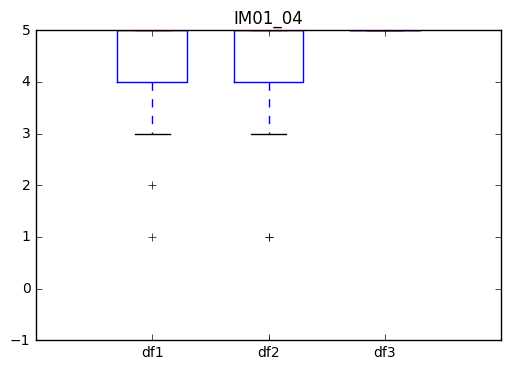

In [14]:
def plot_sig_feats(df, zipper, df_names, feats=None, save_folder=None):
    """ """
    
    # grab significant deviances
    sig_entries = df[df["signf"]]
    index_labels = sig_entries.index.labels[0]
    sig_feats = set(itemgetter(index_labels)(sig_entries.index.levels[0]))
    
    sig_zipper = {x:zipper[x] for x in sig_feats}
    single_feature_bp(sig_zipper, df_names, feats=None, save_folder=None)

plot_sig_feats(x, zipper, df_names, feats=None, save_folder=None)